In [1]:
import sys
sys.path.append('..')
import torch
import numpy as np
import matplotlib.pyplot as plt
from sympy import simplify_logic

from deep_logic.utils.base import validate_network
from deep_logic.utils.relunn import get_reduced_model, prune_features
from deep_logic import fol
import deep_logic as dl

torch.manual_seed(0)
np.random.seed(0)

In [2]:
# XOR problem
x_train = torch.tensor([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1],
], dtype=torch.float)
y_train = torch.tensor([0, 1, 1, 0], dtype=torch.long)
n_classes = len(torch.unique(y_train))

x_test = torch.tensor([
    [0, 0.95],
    [0, 0.9],
    [0.05, 1],
    [0.1, 0.8],
    [0.45, 1],
    [0, 0.35],
    [0.95, 0.9],
    [0.75, 0.2],
    [0.75, 0.15],
], dtype=torch.float)
y_test = torch.tensor([1, 1, 1, 1, 1, 0, 0, 1, 1], dtype=torch.long)

In [3]:
layers = [
    torch.nn.Linear(x_train.size(1), 10 * n_classes),
    torch.nn.ReLU(),
    dl.nn.XLinear(10, 4, n_classes),
    torch.nn.ReLU(),
    dl.nn.XLinear(4, 1, n_classes),
    torch.nn.Sigmoid(),
]
model = torch.nn.Sequential(*layers)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_form = torch.nn.CrossEntropyLoss()
model.train()
need_pruning = True
for epoch in range(400):
    # forward pass
    optimizer.zero_grad()
    y_pred = model(x_train)
    # Compute Loss
    loss = loss_form(y_pred, y_train)

    for module in model.children():
        if isinstance(module, torch.nn.Linear):
            loss += 0.001 * torch.norm(module.weight, 1)

    # backward pass
    loss.backward()
    optimizer.step()
    
    if epoch > 200 and need_pruning:
        prune_features(model, n_classes)
        need_pruning = False

    # compute accuracy
    if epoch % 100 == 0:
        y_pred_d = torch.argmax(y_pred, dim=1)
        accuracy = y_pred_d.eq(y_train).sum().item() / y_train.size(0)
        print(f'Epoch {epoch}: train accuracy: {accuracy:.4f}')

Epoch 0: train accuracy: 0.5000
Epoch 100: train accuracy: 1.0000
Epoch 200: train accuracy: 1.0000
Epoch 300: train accuracy: 1.0000


# Decision boundaries

In [4]:
def plot_decision_bundaries(model, x, h=0.1, cmap='BrBG', torch_model=True, target_class=0):
    x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                           np.arange(x2_min, x2_max, h))
    if torch_model:
        xx = torch.FloatTensor(np.c_[xx1.ravel(), xx2.ravel()])
        Z = model(xx).detach().numpy()[:, target_class]
    else:
        xx = np.c_[xx1.ravel(), xx2.ravel()]
        Z = model.predict_proba(xx)[:, 1]
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.2, cmap=cmap)
    return

## True decision boundaries

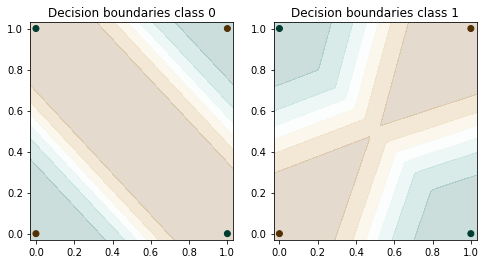

In [5]:
xnp = x_train.detach().numpy()
ynp = y_train.detach().numpy().ravel()
cmap='BrBG'

plt.figure(figsize=[8, 4])
plt.subplot(121)
plt.title(f'Decision boundaries class 0')
plot_decision_bundaries(model, x_train, h=0.01, cmap=cmap)
plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
plt.xlim([-0.03, 1.03])
plt.ylim([-0.03, 1.03])
plt.subplot(122)
plt.title(f'Decision boundaries class 1')
plot_decision_bundaries(model, x_train, h=0.01, cmap=cmap, target_class=1)
plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
plt.xlim([-0.03, 1.03])
plt.ylim([-0.03, 1.03])
plt.show()

## Local decision boundaries

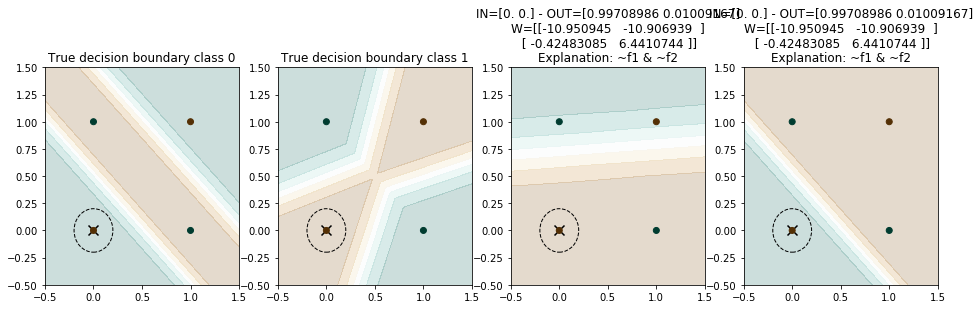

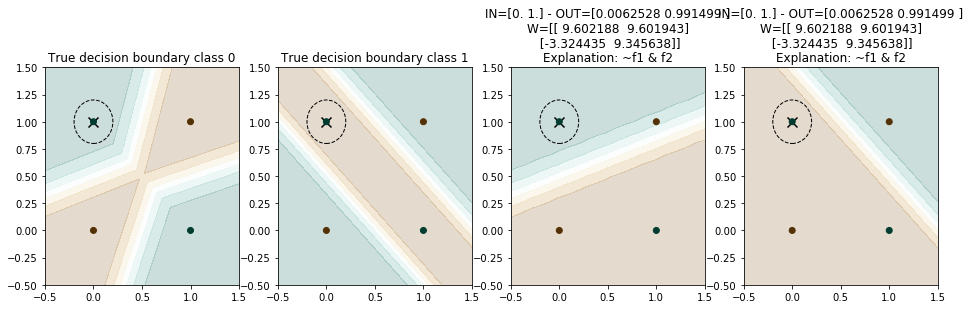

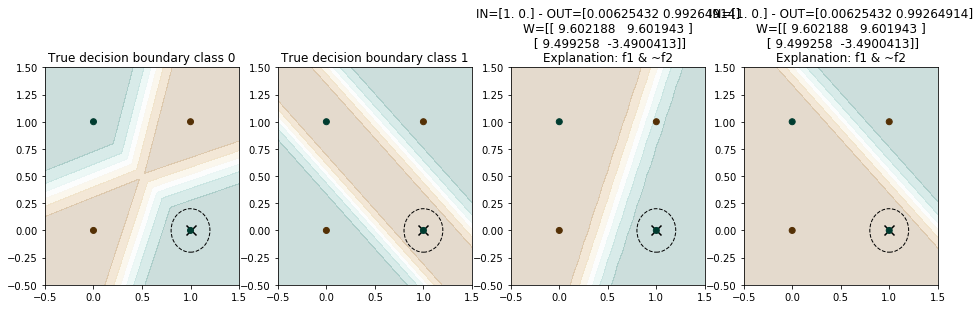

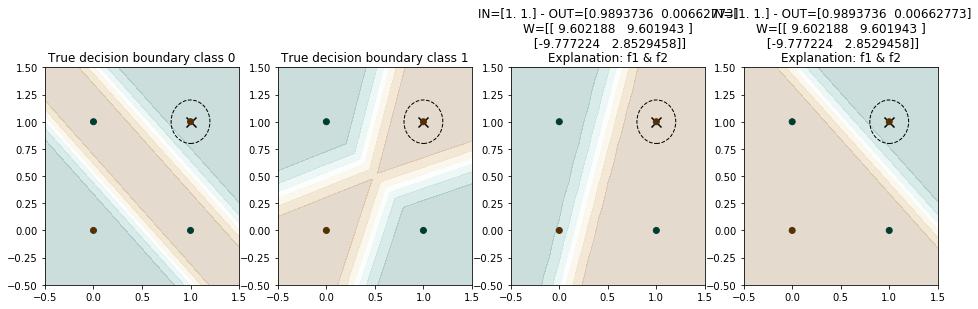

In [6]:
for sample_id in range(len(y_train)):
    xin = x_train[sample_id]
    model_reduced = get_reduced_model(model, xin)
    for module in model_reduced.children():
        if isinstance(module, torch.nn.Linear):
            wa = module.weight.detach().numpy()
            break
    output = model_reduced(xin)
    target_class = torch.argmax(output).item()
    explanation = fol.relunn.explain_local(model, x_train, y_train, 
                                           xin, concept_names=['f1', 'f2'])
    
    model_class = target_class if y_train[sample_id] == 1 else 1-target_class

    plt.figure(figsize=[16, 4])
    plt.subplot(141)
    plt.title(f'True decision boundary class 0')
    plot_decision_bundaries(model, x_train, h=0.01, cmap=cmap, target_class=target_class)
    plt.scatter(xin[0], xin[1], c='k', marker='x', s=100)
    c = plt.Circle((xin[0], xin[1]), radius=0.2, edgecolor='k', fill=False, linestyle='--')
    plt.gca().add_artist(c)
    plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
    plt.xlim([-0.5, 1.5])
    plt.ylim([-0.5, 1.5])
    plt.subplot(142)
    plt.title(f'True decision boundary class 1')
    plot_decision_bundaries(model, x_train, h=0.01, cmap=cmap, target_class=1-target_class)
    plt.scatter(xin[0], xin[1], c='k', marker='x', s=100)
    c = plt.Circle((xin[0], xin[1]), radius=0.2, edgecolor='k', fill=False, linestyle='--')
    plt.gca().add_artist(c)
    plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
    plt.xlim([-0.5, 1.5])
    plt.ylim([-0.5, 1.5])
    plt.subplot(143)
    plt.title(f'IN={xin.detach().numpy()} - OUT={output.detach().numpy()}\nW={wa}\nExplanation: {explanation}')
    plot_decision_bundaries(model_reduced, x_train, target_class=model_class)
    plt.scatter(xin[0], xin[1], c='k', marker='x', s=100)
    c = plt.Circle((xin[0], xin[1]), radius=0.2, edgecolor='k', fill=False, linestyle='--')
    plt.gca().add_artist(c)
    plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
    plt.xlim([-0.5, 1.5])
    plt.ylim([-0.5, 1.5])
    plt.subplot(144)
    plt.title(f'IN={xin.detach().numpy()} - OUT={output.detach().numpy()}\nW={wa}\nExplanation: {explanation}')
    plot_decision_bundaries(model_reduced, x_train, target_class=1-model_class)
    plt.scatter(xin[0], xin[1], c='k', marker='x', s=100)
    c = plt.Circle((xin[0], xin[1]), radius=0.2, edgecolor='k', fill=False, linestyle='--')
    plt.gca().add_artist(c)
    plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
    plt.xlim([-0.5, 1.5])
    plt.ylim([-0.5, 1.5])
    plt.show()

# Combine local explanations

In [7]:
explanation, predictions, counter = fol.relunn.combine_local_explanations(model, x_train, y_train,
                                                                         target_class=0, 
                                                                          concept_names=['x1', 'x2'])
explanation

'(x1 & x2) | (~x1 & ~x2)'

In [8]:
explanation, predictions, counter = fol.relunn.combine_local_explanations(model, x_train, y_train,
                                                                         target_class=1, 
                                                                          concept_names=['x1', 'x2'])
explanation